In [ ]:
pip install opendatasets

In [ ]:
!pip install openTSNE


# Credentials to Download Kaggle Data
username:"gabrielcarson"

key:"37f051470fcebe79fb76b6f950b66744"

In [ ]:
import opendatasets as od

od.download("https://www.kaggle.com/competitions/football-match-probability-prediction/data?select=test.csv")

Skipping, found downloaded files in "./football-match-probability-prediction" (use force=True to force download)


# Load Test Data

In [ ]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.metrics import accuracy_score, log_loss
from collections import Counter
import random
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Load Data
trainfile = 'football-match-probability-prediction/train.csv'
testfile = 'football-match-probability-prediction/test.csv'

# Load the data
train = pd.read_csv(trainfile)
test = pd.read_csv(testfile)

# Drop rows with missing most recent match date for the home team
train = train.dropna(subset=['home_team_history_match_date_1'])

# Identify Descriptive Columns
descriptive_columns = [
    "home_team_name", "away_team_name", "match_date",
    "league_name", "is_cup", "home_team_coach_id", "away_team_coach_id"
]

# Separate Target Column and Features
train_y = train["target"]
train_x = train.drop(columns=["target"])
test_x = test.copy()

# Map Labels to Integers
label_mapping = {'home': 0, 'away': 1, 'draw': 2}
train_y = train_y.map(label_mapping)

# Convert Dates to Numeric Days
def process_dates(df, reference_date):
    for col in df.columns:
        if 'match_date' in col:
            df[col] = (pd.to_datetime(df[col]) - pd.to_datetime(reference_date)).dt.days
    return df

train_x = process_dates(train_x, train['match_date'])
test_x = process_dates(test_x, test['match_date'])

# Remove Descriptive Columns After Processing
train_x = train_x.drop(columns=descriptive_columns)
test_x = test_x.drop(columns=descriptive_columns)

# Replace NaN and Inf with 0.0
train_x = np.nan_to_num(train_x, nan=0.0, posinf=0.0, neginf=0.0)
test_x = np.nan_to_num(test_x, nan=0.0, posinf=0.0, neginf=0.0)

# Debugging
print(f"Train Features Shape: {train_x.shape}")
print(f"Test Features Shape: {test_x.shape}")


<ipython-input-78-c9c5b0ed9446>:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(trainfile)


Train Features Shape: (109779, 182)
Test Features Shape: (72711, 182)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on train_x and transform both train_x and test_x
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

# Debugging
print(f"Train Scaled Shape: {train_x_scaled.shape}")
print(f"Test Scaled Shape: {test_x_scaled.shape}")

Train Scaled Shape: (109779, 182)
Test Scaled Shape: (72711, 182)


# Feature Reduction

### PCA

In [ ]:
def pca(data, target, is_error_rate=False):
    """
    Perform PCA on the given dataset.

    Parameters:
    data (ndarray): The dataset (without labels) to perform PCA on.
    target (float): Desired dimension or error rate. If less than 1, it's treated as an error rate.
    is_error_rate (bool): If True, 'target' is considered as the desired error rate.

    Returns:
    P (ndarray): The projection matrix.
    retained_error (float): The resulting error rate.
    """
    # Center the data (mean of 0)
    mean = np.mean(data, axis=0)
    data_centered = data - mean

    # Compute the covariance matrix
    covariance_matrix = np.cov(data_centered, rowvar=False)

    # Eigen decomposition of the covariance matrix
    eigvals, eigvecs = np.linalg.eigh(covariance_matrix)

    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:, sorted_indices]

    # Calculate cumulative explained variance
    cumulative_variance = np.cumsum(eigvals) / np.sum(eigvals)

    if is_error_rate:
        # Determine number of components based on error rate
        num_components = np.argmax(cumulative_variance >= (1 - target)) + 1
        retained_error = 1 - cumulative_variance[num_components - 1]
    else:
        # Determine retained error based on target dimension
        num_components = int(target)
        retained_error = 1 - cumulative_variance[num_components - 1]

    # Projection matrix using selected components
    P = eigvecs[:, :num_components]
    return P, retained_error

### FLD

In [ ]:
def compute_fld(x_train, y_train, num_classes, epsilon=1e-6):
    """
    Compute the Fisher Linear Discriminant projection matrix for dimensionality reduction.

    Parameters:
    x_train (ndarray): Standardized training data of shape (num_samples, num_features).
    y_train (ndarray): Training labels of shape (num_samples,).
    num_classes (int): Number of unique classes (for MNIST, this is 10).
    epsilon (float): Small value to add to the diagonal of S_W to avoid singular matrix.

    Returns:
    W (ndarray): The projection matrix of shape (num_features, num_classes - 1).
    """
    # Compute overall mean
    overall_mean = np.mean(x_train, axis=0)

    # Initialize within-class and between-class scatter matrices
    num_features = x_train.shape[1]
    S_W = np.zeros((num_features, num_features))
    S_B = np.zeros((num_features, num_features))

    for c in range(num_classes):
        # Extract samples for the class
        x_c = x_train[y_train == c]
        mean_c = np.mean(x_c, axis=0)

        # Compute within-class scatter matrix
        S_W += np.dot((x_c - mean_c).T, (x_c - mean_c))

        # Compute between-class scatter matrix
        n_c = x_c.shape[0]  # Number of samples in class
        mean_diff = (mean_c - overall_mean).reshape(-1, 1)
        S_B += n_c * (mean_diff).dot(mean_diff.T)

    # Add epsilon to the diagonal of S_W to avoid singular matrix
    S_W += epsilon * np.eye(num_features)

    # Solve the generalized eigenvalue problem for SW^-1 * SB
    eigvals, eigvecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

    # Sort eigenvectors by eigenvalues in descending order
    sorted_indices = np.argsort(eigvals)[::-1]
    W = np.real(eigvecs[:, sorted_indices[:num_classes - 1]])  # Take the top 'num_classes - 1' eigenvectors

    return W

#### Pre-process

In [ ]:
# Apply PCA
error_threshold = 0.05  # Use the desired number of PCA components
P_pca, retained_error = pca(train_x_scaled, error_threshold, is_error_rate=False)

# Project data onto PCA components
train_pca = np.dot(train_x_scaled, P_pca)
test_pca = np.dot(test_x_scaled, P_pca)

print(f"Train PCA Shape: {train_pca.shape}")
print(f"Test PCA Shape: {test_pca.shape}")
print(f"PCA Retained Error: {retained_error}")

# Step 2: Apply FLD on PCA-reduced data
num_classes = len(np.unique(train_y))  # Number of unique classes in labels
fld_projection_matrix = compute_fld(train_pca, train_y, num_classes)

# Project data onto FLD components
train_pca_fld = np.dot(train_pca, fld_projection_matrix)
test_pca_fld = np.dot(test_pca, fld_projection_matrix)

print(f"Train PCA + FLD Shape: {train_pca_fld.shape}")
print(f"Test PCA + FLD Shape: {test_pca_fld.shape}")



Train PCA Shape: (109779, 123)
Test PCA Shape: (72711, 123)
PCA Retained Error: 0.04916458684661351
Train PCA + FLD Shape: (109779, 2)
Test PCA + FLD Shape: (72711, 2)


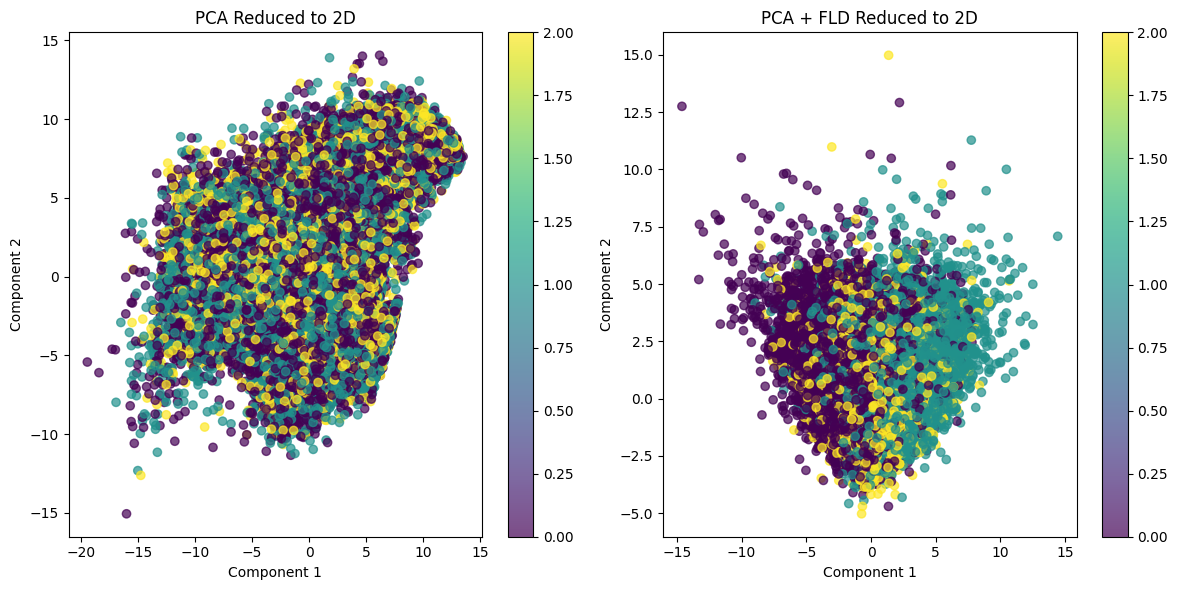

In [ ]:
# Reduce PCA data to 2D for visualization
pca_2d_projection, _ = pca(train_pca, 2, is_error_rate=False)
train_pca_2d = np.dot(train_pca, pca_2d_projection)

# Reduce PCA + FLD data to 2D for visualization
fld_pca_projection, _ = pca(train_pca_fld, 2, is_error_rate=False)
train_pca_fld_2d = np.dot(train_pca_fld, fld_pca_projection)

# Plot PCA-only and PCA + FLD 2D data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(train_pca_2d[:, 0], train_pca_2d[:, 1], c=train_y, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title("PCA Reduced to 2D")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

plt.subplot(1, 2, 2)
plt.scatter(train_pca_fld_2d[:, 0], train_pca_fld_2d[:, 1], c=train_y, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title("PCA + FLD Reduced to 2D")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

plt.tight_layout()
plt.show()


### t-SNE

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Compute Pairwise Distances
def compute_pairwise_distances(data):
    """Compute pairwise Euclidean distances for all points."""
    n = data.shape[0]
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist = np.linalg.norm(data[i] - data[j])
            distances[i, j] = distances[j, i] = dist
    return distances

# Step 2: Convert Distances to Probabilities
def compute_conditional_probabilities(distances, perplexity):
    """Compute conditional probabilities using a Gaussian kernel."""
    def binary_search_beta(distances_i, target_perplexity, tol=1e-5, max_iter=50):
        """Binary search for beta to achieve the target perplexity."""
        beta = 1.0
        for _ in range(max_iter):
            p_i = np.exp(-distances_i * beta)
            p_i /= np.sum(p_i)
            perplexity_i = np.exp(-np.sum(p_i * np.log2(p_i + 1e-10)))
            if np.abs(perplexity_i - target_perplexity) < tol:
                break
            if perplexity_i > target_perplexity:
                beta *= 2.0
            else:
                beta /= 2.0
        return beta, p_i

    n = distances.shape[0]
    target_perplexity = perplexity
    probabilities = np.zeros_like(distances)
    for i in range(n):
        beta, p_i = binary_search_beta(distances[i], target_perplexity)
        probabilities[i, :] = p_i
    return probabilities

# Step 3: Initialize Low-Dimensional Embeddings
def initialize_low_dimensional_data(n, dim=2):
    """Initialize points in low-dimensional space."""
    return np.random.randn(n, dim) * 1e-4

# Step 4: Compute Gradient for KL Divergence
def compute_gradient(y, p_high, dim):
    """Compute the gradient for KL divergence."""
    n = y.shape[0]
    p_low = np.zeros_like(p_high)
    for i in range(n):
        for j in range(n):
            if i != j:
                q_ij = 1 / (1 + np.linalg.norm(y[i] - y[j]) ** 2)
                p_low[i, j] = q_ij
    p_low /= np.sum(p_low)

    gradient = np.zeros_like(y)
    for i in range(n):
        for j in range(n):
            if i != j:
                grad = (p_high[i, j] - p_low[i, j]) * (y[i] - y[j]) / (1 + np.linalg.norm(y[i] - y[j]) ** 2)
                gradient[i] += grad
    return gradient

# Step 5: Perform Gradient Descent
def tsne1(data, perplexity=30, n_iter=1000, learning_rate=200, dim=2):
    """Manually implement t-SNE."""
    distances = compute_pairwise_distances(data)
    p_high = compute_conditional_probabilities(distances, perplexity)
    p_high = (p_high + p_high.T) / (2 * np.sum(p_high))  # Symmetrize

    y = initialize_low_dimensional_data(data.shape[0], dim)
    for iteration in range(n_iter):
        gradient = compute_gradient(y, p_high, dim)
        y -= learning_rate * gradient
        if iteration % 20 == 0:
            print(f"Iteration {iteration}, Gradient Norm: {np.linalg.norm(gradient):.4f}")
    return y

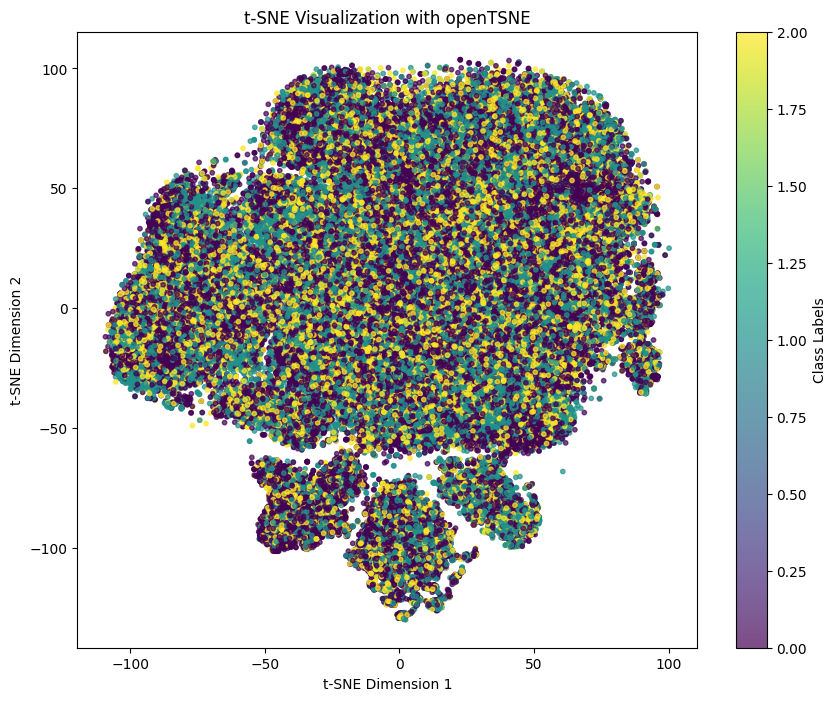

In [ ]:
from openTSNE import TSNE
import matplotlib.pyplot as plt

# Use PCA-reduced data
subset_pca = train_pca  # Subset for faster computation
subset_labels = train_y  # Ensure consistency with current variable names

# Apply t-SNE
tsne = TSNE(n_jobs=4, perplexity=30, n_iter=1000, random_state=42)  # n_jobs for CPU parallelism
low_dim_embeddings = tsne.fit(subset_pca)

# Visualize t-SNE Results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    low_dim_embeddings[:, 0], low_dim_embeddings[:, 1], c=subset_labels, cmap='viridis', s=10, alpha=0.7
)
plt.colorbar(scatter, label='Class Labels')
plt.title("t-SNE Visualization with openTSNE")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# Classification

### Bayesian Decision Rule/Maximum Posterior Probability (Bayesian / Supervised / Parametric)
MPP with Eculidean and Mahalanobis Distance

In [ ]:
def mpp_classifier_with_probabilities(train_data, train_labels, test_data, metric="euclidean"):
    """
    MPP Classifier to compute probabilities for each class.

    Parameters:
    train_data (ndarray): Training data.
    train_labels (ndarray): Labels for training data.
    test_data (ndarray): Test data.
    metric (str): Distance metric ("euclidean" or "mahalanobis").

    Returns:
    ndarray: Predicted probabilities (rows: test samples, cols: classes).
    """
    class_means = {}
    class_covariances = {}

    # Compute class means and covariances
    for c in np.unique(train_labels):
        class_indices = (train_labels == c)
        class_data = train_data[class_indices, :]
        class_means[c] = np.mean(class_data, axis=0)

        if metric == "mahalanobis":
            class_covariances[c] = np.cov(class_data, rowvar=False)

    probabilities = []
    for test_point in test_data:
        distances = {}

        for c in class_means:
            mean = class_means[c]

            if metric == "euclidean":
                distances[c] = np.linalg.norm(test_point - mean)
            elif metric == "mahalanobis":
                covariance = class_covariances[c]
                inv_covariance = inv(covariance + 1e-6 * np.eye(covariance.shape[0]))  # Add small stability value
                distances[c] = np.sqrt((test_point - mean).T @ inv_covariance @ (test_point - mean))
            else:
                raise ValueError("Unsupported metric: Choose 'euclidean' or 'mahalanobis'.")

        # Convert distances to probabilities
        inv_distances = {c: 1 / d if d != 0 else 1e-10 for c, d in distances.items()}
        total_inv_distance = sum(inv_distances.values())
        prob = [inv_distances[c] / total_inv_distance for c in sorted(class_means.keys())]
        probabilities.append(prob)

    return np.array(probabilities)


### Back-Propogating Neural Network

In [ ]:
class Network:
    def __init__(self, sizes):
        """The list `sizes` contains the number of neurons in the respective layers of the network.
        For example, if the list was [2, 3, 1] then it would be a three-layer network, with the first
        layer containing 2 neurons, the second layer 3 neurons, and the third layer 1 neuron.
        The biases and weights for the network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1. Note that the first layer is assumed to be an input
        layer, and by convention we won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        """Train the neural network using mini-batch stochastic gradient descent."""
        training_data = list(training_data)
        n = len(training_data)
        accuracy_list = []

        if test_data:
            test_data = list(test_data)
            n_test = len(test_data)

        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                correct = self.evaluate(test_data)
                accuracy = correct / n_test
                accuracy_list.append(accuracy)

        return accuracy_list


    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying gradient descent using backpropagation
        to a single mini batch. The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta`` is the
        learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w - (eta / len(mini_batch)) * nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta / len(mini_batch)) * nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the gradient for the cost function C_x.
        ``nabla_b`` and ``nabla_w`` are layer-by-layer lists of numpy arrays, similar to ``self.biases``
        and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # Reshape x to (784, 1) to ensure it's a column vector
        activation = x.reshape((-1, 1))
        activations = [activation]  # list to store all the activations, layer by layer
        zs = []  # list to store all the z vectors, layer by layer

        # Forward pass
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)

        # Output activations should be (10, 1) and y should be (10, 1)
        output_activations = activations[-1]
        y = y.reshape((-1, 1))  # Reshape y to match (10, 1)

        # Backward pass - comparing final layer activations with labels
        delta = self.cost_derivative(output_activations, y) * sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())

        # Update delta for each layer
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l + 1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l - 1].transpose())

        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural network outputs the correct result.
        The neural network's output is assumed to be the index of whichever neuron in the final layer
        has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), np.argmax(y)) for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)


    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives /partial C_x / /partial a for the output activations."""
        return (output_activations - y)

def sigmoid(z):
    """The sigmoid function."""
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z) * (1 - sigmoid(z))

In [ ]:
def compute_nn_predictions(network, data):
    """
    Compute predictions for the data using the trained network.

    Parameters:
    network (Network): Trained neural network instance.
    data (list of tuples): List of (feature, label) pairs.

    Returns:
    np.ndarray: Predicted probabilities for each class.
    np.ndarray: True labels.
    """
    predictions = []
    true_labels = []
    for x, y in data:
        predicted_probs = network.feedforward(x).flatten()
        predictions.append(predicted_probs)
        true_labels.append(np.argmax(y))  # Convert one-hot to integer class

    return np.array(predictions), np.array(true_labels)


### Random Forest Classifier

In [ ]:

def random_forest_with_kfold(train_data, train_labels, val_data, val_labels, k=5):
    """
    Train and evaluate Random Forest using k-Fold Cross-Validation and compute Log Loss.
    """
    random_forest = RandomForestClassifier(
        n_estimators=100,  # Number of trees
        max_depth=None,    # Maximum depth of the trees
        random_state=42,   # For reproducibility
        n_jobs=-1          # Use all processors for training
    )

    # Use custom k-fold cross-validation
    mean_log_loss = k_fold_cross_validation(
        data=train_data,
        labels=train_labels,
        k=k,
        classifier_fn=lambda tr_data, tr_labels, te_data: fit_predict_random_forest(random_forest, tr_data, tr_labels, te_data)
    )

    # Train the model on the full training dataset
    random_forest.fit(train_data, train_labels)
    val_predictions = random_forest.predict_proba(val_data)
    val_log_loss = log_loss(val_labels, val_predictions)

    return mean_log_loss, val_log_loss


# Helper Function to fit and predict with Random Forest
def fit_predict_random_forest(model, train_data, train_labels, test_data):
    """
    Train Random Forest and return predicted probabilities for the test set.
    """
    model.fit(train_data, train_labels)
    return model.predict_proba(test_data)



### Hierarchical Agglomerative Clustering (Non-Bayesian / Unsupervised / Non-Parametric)

In [ ]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

def hierarchical_agglomerative_clustering_fraction(train_data, train_labels, test_data, k, batch_size=5000, fraction=0.1):
    """
    Perform hierarchical agglomerative clustering (HAC) with Ward linkage on a fraction of the data
    and calculate class probabilities for test data in batches.

    Parameters:
    train_data (ndarray): Preprocessed training data (num_samples, num_features).
    train_labels (ndarray): Labels for training data (num_samples,).
    test_data (ndarray): Preprocessed test data (num_test_samples, num_features).
    k (int): Number of clusters.
    batch_size (int): Size of each batch for processing test data.
    fraction (float): Fraction of the dataset to use (0 < fraction <= 1).

    Returns:
    ndarray: Predicted probabilities for each class (num_test_samples, num_classes).
    """
    # Ensure the fraction is valid
    if not (0 < fraction <= 1):
        raise ValueError("Fraction must be between 0 and 1.")

    # Sample a fraction of the training data
    n_train_samples = int(train_data.shape[0] * fraction)
    sampled_indices = np.random.choice(train_data.shape[0], n_train_samples, replace=False)
    sampled_train_data = train_data[sampled_indices]
    sampled_train_labels = train_labels[sampled_indices]

    num_classes = np.max(sampled_train_labels) + 1

    # Step 1: Fit HAC on the sampled training data
    hc = AgglomerativeClustering(n_clusters=k, linkage='ward')
    train_assignments = hc.fit_predict(sampled_train_data)

    # Step 2: Compute cluster-to-class probabilities
    cluster_class_probabilities = np.zeros((k, num_classes))
    for cluster_id in range(k):
        cluster_indices = np.where(train_assignments == cluster_id)[0]
        if len(cluster_indices) > 0:
            class_counts = np.bincount(sampled_train_labels[cluster_indices], minlength=num_classes)
            cluster_class_probabilities[cluster_id] = class_counts / np.sum(class_counts)

    # Step 3: Process test data in batches
    n_test_samples = test_data.shape[0]
    probabilities = np.zeros((n_test_samples, num_classes))

    for start_idx in range(0, n_test_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_test_samples)
        batch_data = test_data[start_idx:end_idx]

        # Compute distances and cluster assignments for the batch
        distance_matrix = pairwise_distances(batch_data, sampled_train_data, metric='euclidean')
        batch_assignments = np.argmin(distance_matrix, axis=1)

        # Handle invalid cluster assignments (e.g., if batch_assignments contains invalid indices)
        batch_assignments = np.clip(batch_assignments, 0, k - 1)

        # Assign probabilities for the batch
        probabilities[start_idx:end_idx] = cluster_class_probabilities[batch_assignments]

    return probabilities


### Behavior-Knowledge Space

In [ ]:
from scipy.stats import mode
from collections import defaultdict

def create_bks_table(predictions_1, predictions_2, true_labels):
    """
    Create a BKS table from two sets of classifier predictions and the true labels.

    Parameters:
    predictions_1 (ndarray): Predictions from the first classifier.
    predictions_2 (ndarray): Predictions from the second classifier.
    true_labels (ndarray): True labels for the training data.

    Returns:
    dict: BKS table mapping (pred_1, pred_2) tuples to the most frequent true label.
    """
    bks_table = defaultdict(list)

    # Collect true labels for each pair of predictions
    for pred_1, pred_2, true_label in zip(predictions_1, predictions_2, true_labels):
        bks_table[(pred_1, pred_2)].append(true_label)

    # Debugging: Check the raw BKS table contents
    print(f"Raw BKS table before reduction: {dict(bks_table)}")

    # Reduce to the most frequent true label for each prediction pair
    reduced_table = {}
    for key, val in bks_table.items():
        if len(val) > 0:  # Ensure the list is not empty
            most_frequent = mode(val, keepdims=True).mode
            if len(most_frequent) > 0:  # Ensure the mode is not empty
                reduced_table[key] = most_frequent[0]
            else:
                reduced_table[key] = -1  # Assign a fallback for unexpected empty mode
        else:
            reduced_table[key] = -1  # Assign a fallback for empty lists

    # Debugging: Check the reduced BKS table
    print(f"Reduced BKS table: {reduced_table}")

    return reduced_table

In [ ]:
from collections import defaultdict, Counter

def create_probabilistic_bks_table(predictions_1, predictions_2, true_labels):
    """
    Create a probabilistic BKS table for fusion.

    Parameters:
    predictions_1 (ndarray): Predictions from the first classifier.
    predictions_2 (ndarray): Predictions from the second classifier.
    true_labels (ndarray): True labels for the training data.

    Returns:
    dict: BKS table mapping (pred_1, pred_2) to class probabilities.
    """
    bks_table = defaultdict(Counter)

    # Populate the table with class counts
    for pred_1, pred_2, true_label in zip(predictions_1, predictions_2, true_labels):
        bks_table[(pred_1, pred_2)][true_label] += 1

    # Normalize to probabilities
    prob_bks_table = {}
    for key, counts in bks_table.items():
        total = sum(counts.values())
        prob_bks_table[key] = {cls: count / total for cls, count in counts.items()}

    return prob_bks_table


In [ ]:
def bks_predict_with_probabilities(predictions_1, predictions_2, prob_bks_table, num_classes):
    """
    Predict using a probabilistic BKS table.

    Parameters:
    predictions_1 (ndarray): Predictions from the first classifier.
    predictions_2 (ndarray): Predictions from the second classifier.
    prob_bks_table (dict): BKS table with class probabilities.
    num_classes (int): Number of classes.

    Returns:
    ndarray: Predicted probabilities for each class.
    """
    probs = np.zeros((len(predictions_1), num_classes))

    for i, (pred_1, pred_2) in enumerate(zip(predictions_1, predictions_2)):
        if (pred_1, pred_2) in prob_bks_table:
            # Use the stored probabilities
            for cls, prob in prob_bks_table[(pred_1, pred_2)].items():
                probs[i, cls] = prob
        else:
            # Assign uniform probabilities for unseen pairs
            probs[i, :] = 1 / num_classes

    return probs


### Train-Test Split

In [ ]:
# Assuming the PCA + FLD transformed datasets are `train_pca_fld` and `test_pca_fld`
# Perform a train-test split on the PCA + FLD data
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_pca_fld_split, val_pca_fld_split, train_y_split, val_y_split = train_test_split(
    train_pca_fld, train_y, test_size=0.2, random_state=42
)

# Convert train_y_split and val_y_split to NumPy arrays for consistency
train_y_split = np.array(train_y_split)
val_y_split = np.array(val_y_split)


print(f"Train PCA + FLD Split Shape: {train_pca_fld_split.shape}")
print(f"Validation PCA + FLD Split Shape: {val_pca_fld_split.shape}")


Train PCA + FLD Split Shape: (87823, 2)
Validation PCA + FLD Split Shape: (21956, 2)


### Fusion Processing

In [ ]:
# Generate predictions for Mahalanobis on training and test data
train_predictions_mahalanobis = np.argmax(
    mpp_classifier_with_probabilities(train_pca_fld, train_y, train_pca_fld, metric="mahalanobis"),
    axis=1
)
test_predictions_mahalanobis = np.argmax(
    mpp_classifier_with_probabilities(train_pca_fld, train_y, val_pca_fld_split, metric="mahalanobis"),
    axis=1
)

# Generate predictions for Euclidean on training and test data
train_predictions_euclidean = np.argmax(
    mpp_classifier_with_probabilities(train_pca_fld, train_y, train_pca_fld, metric="euclidean"),
    axis=1
)
test_predictions_euclidean = np.argmax(
    mpp_classifier_with_probabilities(train_pca_fld, train_y, val_pca_fld_split, metric="euclidean"),
    axis=1
)


In [ ]:
# Generate Euclidean predictions
val_predictions_euclidean = np.argmax(
    mpp_classifier_with_probabilities(train_pca_fld_split, train_y_split, val_pca_fld_split, metric="euclidean"),
    axis=1
)

# Generate Mahalanobis predictions
val_predictions_mahalanobis = np.argmax(
    mpp_classifier_with_probabilities(train_pca_fld_split, train_y_split, val_pca_fld_split, metric="mahalanobis"),
    axis=1
)

# Print unique predictions for debugging
print("Unique Predictions (Euclidean):", np.unique(val_predictions_euclidean))
print("Unique Predictions (Mahalanobis):", np.unique(val_predictions_mahalanobis))


Unique Predictions (Euclidean): [0 1 2]
Unique Predictions (Mahalanobis): [0 1 2]


# Performance Evaluation

### Log Loss

In [ ]:
def compute_log_loss(true_labels, predicted_probs, epsilon=1e-15):
    """
    Compute the log loss for multi-class classification.

    Parameters:
    true_labels (ndarray): True class labels (encoded as integers, e.g., 0, 1, 2).
    predicted_probs (ndarray): Predicted probabilities for each class (rows: samples, cols: classes).
    epsilon (float): Small value to avoid log(0).

    Returns:
    float: Log loss value.
    """
    # Ensure probabilities are in a valid range
    predicted_probs = np.clip(predicted_probs, epsilon, 1 - epsilon)

    # Get the probabilities for the true classes
    true_class_probs = predicted_probs[np.arange(len(true_labels)), true_labels]

    # Compute log loss
    log_loss = -np.mean(np.log(true_class_probs))
    return log_loss

### Cross Validation

In [ ]:
def k_fold_cross_validation(data, labels, k, classifier_fn, **kwargs):
    """
    Perform k-fold cross-validation manually.

    Parameters:
    data (ndarray): Input data for classification.
    labels (ndarray): True class labels (encoded as integers).
    k (int): Number of folds.
    classifier_fn (function): A function to train and predict, returning predicted probabilities.
    **kwargs: Additional parameters to pass to the classifier function.

    Returns:
    float: Average log loss across all folds.
    """
    n_samples = data.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)  # Shuffle the data

    fold_size = n_samples // k
    log_losses = []

    for fold in range(k):
        # Define fold indices
        start = fold * fold_size
        end = (fold + 1) * fold_size if fold != k - 1 else n_samples
        test_indices = indices[start:end]
        train_indices = np.concatenate((indices[:start], indices[end:]))

        # Split data
        train_data, train_labels = data[train_indices], labels[train_indices]
        test_data, test_labels = data[test_indices], labels[test_indices]

        # Predict probabilities using the classifier
        predicted_probs = classifier_fn(train_data, train_labels, test_data, **kwargs)

        # Compute log loss for this fold
        log_loss = compute_log_loss(test_labels, predicted_probs)
        log_losses.append(log_loss)

    return np.mean(log_losses)


### Evaluate Euclidean Classifier with Cross Validation + Log Loss

In [ ]:
# Ensure train_pca_fld and train_y are numpy arrays
train_pca_fld = np.asarray(train_pca_fld)
train_y = np.asarray(train_y)

# Wrapper for MPP classifier
def classifier_wrapper(train_data, train_labels, test_data, metric="euclidean"):
    return mpp_classifier_with_probabilities(train_data, train_labels, test_data, metric=metric)

# Perform k-fold cross-validation (PCA + FLD data)
k = 10  # Number of folds

# Evaluate with Euclidean metric
fld_euclidean_log_loss = k_fold_cross_validation(
    train_pca_fld, train_y, k,
    lambda tr_data, tr_labels, te_data: classifier_wrapper(tr_data, tr_labels, te_data, metric="euclidean")
)

# Evaluate with Mahalanobis metric
fld_mahalanobis_log_loss = k_fold_cross_validation(
    train_pca_fld, train_y, k,
    lambda tr_data, tr_labels, te_data: classifier_wrapper(tr_data, tr_labels, te_data, metric="mahalanobis")
)

# Print results
print("PCA + FLD:")
print(f"Euclidean Log Loss: {fld_euclidean_log_loss:.4f}")
print(f"Mahalanobis Log Loss: {fld_mahalanobis_log_loss:.4f}")


PCA + FLD:
Euclidean Log Loss: 1.0933
Mahalanobis Log Loss: 1.0804


### Use BKS Fusion to Improve MPP Performance

In [ ]:
# Create probabilistic BKS table
prob_bks_table = create_probabilistic_bks_table(train_predictions_euclidean, train_predictions_mahalanobis, train_y)

# Make predictions on validation data
val_probs = bks_predict_with_probabilities(val_predictions_euclidean, val_predictions_mahalanobis, prob_bks_table, num_classes=3)

# Convert probabilities to class predictions
val_predicted_labels = np.argmax(val_probs, axis=1)

# Evaluate
accuracy = accuracy_score(val_y_split, val_predicted_labels)
log_loss_value = compute_log_loss(val_y_split, val_probs)

print(f"BKS Validation Accuracy: {accuracy:.4f}")
print(f"BKS Validation Log Loss: {log_loss_value:.4f}")


BKS Validation Accuracy: 0.4957
BKS Validation Log Loss: 1.0277


### Evaluate HAC and Calculate Log-Loss

In [ ]:
def hierarchical_agglomerative_wrapper_with_fraction(train_data, train_labels, test_data, k, fraction=0.1, batch_size=500):
    """
    Wrapper for HAC with probabilities to fit into the cross-validation framework using a fraction of the training data.

    Parameters:
    train_data (ndarray): Training dataset (num_samples, num_features).
    train_labels (ndarray): Training labels (num_samples,).
    test_data (ndarray): Test dataset to classify (num_test_samples, num_features).
    k (int): Number of clusters.
    fraction (float): Fraction of training data to use (0 < fraction <= 1).
    batch_size (int): Batch size for processing test data.

    Returns:
    ndarray: Predicted probabilities for the test dataset.
    """
    return hierarchical_agglomerative_clustering_fraction(
        train_data, train_labels, test_data, k, batch_size=batch_size, fraction=fraction
    )

# Cross-validation parameters
k_folds = 10  # Number of folds for cross-validation
num_clusters = 4  # Number of clusters
fraction = 0.3  # Use 10% of the training data
batch_size = 3000  # Batch size for test data

# Perform cross-validation for PCA + FLD data
hac_log_loss_pca_fld = k_fold_cross_validation(
    train_pca_fld,  # Preprocessed training data (after PCA + FLD)
    train_y,   # Corresponding labels
    k_folds,        # Number of folds
    lambda tr_data, tr_labels, te_data: hierarchical_agglomerative_wrapper_with_fraction(
        tr_data, tr_labels, te_data, k=num_clusters, fraction=fraction, batch_size=batch_size
    )
)

# Print results
print(f"HAC Log Loss (PCA + FLD, Fraction={fraction}): {hac_log_loss_pca_fld:.4f}")


HAC Log Loss (PCA + FLD, Fraction=0.3): 1.2143


### Evaluate Random Forest

In [ ]:
# Split the data into train and validation sets
train_x_split, val_x_split, train_y_split, val_y_split = train_test_split(
    train_x_scaled, train_y, test_size=0.2, random_state=42
)

train_x_split = train_x_split.to_numpy() if isinstance(train_x_split, pd.DataFrame) else train_x_split
train_y_split = train_y_split.to_numpy() if isinstance(train_y_split, pd.Series) else train_y_split

mean_kfold_log_loss, val_log_loss = random_forest_with_kfold(
    train_x_split, train_y_split, val_x_split, val_y_split, k=k
)

print(f"{k}-Fold Cross-Validation Log Loss: {mean_kfold_log_loss:.4f}")
print(f"Validation Log Loss: {val_log_loss:.4f}")


10-Fold Cross-Validation Log Loss: 1.0327
Validation Log Loss: 1.0272


# Feedback System

### Back-Propogating Neural Network

In [ ]:
# Wrapper function to train and evaluate the BPNN with cross-validation
def bpnn_cross_validation(train_data, train_labels, k, network_params, training_params):
    """
    Perform k-fold cross-validation for the BPNN.

    Parameters:
    train_data (ndarray): Training feature data.
    train_labels (ndarray): Training labels (one-hot encoded).
    k (int): Number of folds.
    network_params (dict): Parameters for the BPNN initialization (e.g., layer sizes).
    training_params (dict): Training parameters (e.g., epochs, batch size, learning rate).

    Returns:
    float: Mean log loss across folds.
    """
    n_samples = train_data.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)  # Shuffle the data
    fold_size = n_samples // k
    log_losses = []

    for fold in range(k):
        # Define fold indices
        start = fold * fold_size
        end = (fold + 1) * fold_size if fold != k - 1 else n_samples
        test_indices = indices[start:end]
        train_indices = np.concatenate((indices[:start], indices[end:]))

        # Split data
        fold_train_data, fold_train_labels = train_data[train_indices], train_labels[train_indices]
        fold_test_data, fold_test_labels = train_data[test_indices], train_labels[test_indices]

        # Initialize and train the BPNN
        bpnn = Network(**network_params)
        training_data = list(zip(fold_train_data, fold_train_labels))
        bpnn.SGD(training_data, **training_params)

        # Compute predictions for the validation set
        test_data = list(zip(fold_test_data, fold_test_labels))
        predicted_probs, true_labels = compute_nn_predictions(bpnn, test_data)

        # Calculate log loss for this fold
        fold_log_loss = compute_log_loss(true_labels, predicted_probs)
        log_losses.append(fold_log_loss)

    return np.mean(log_losses)

# Parameters for BPNN and training
network_params = {"sizes": [train_pca_fld_split.shape[1], 64, 3]}  # Example: input -> 64 hidden -> output
training_params = {"epochs": 10, "mini_batch_size": 32, "eta": 0.01}

# Perform k-fold cross-validation
k = 10
cv_log_loss = bpnn_cross_validation(train_pca_fld_split, train_labels_one_hot, k, network_params, training_params)

print(f"Cross-Validation Log Loss for BPNN: {cv_log_loss:.4f}")



Cross-Validation Log Loss for BPNN: 0.8724
